In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

import numpy as np
from patchify import patchify,unpatchify
import PIL
import matplotlib.pyplot as plt
import os
import logging
import pickle as pk

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from skimage.measure import block_reduce

In [2]:
def show_map(img):
    fig, ax = plt.subplots(figsize = (10,5))
    ax.imshow(img)
    plt.show()

In [3]:
def rotate_crop_map(map_img):
    gray = cv.cvtColor(map_img, cv.COLOR_RGB2GRAY)
    gray = 255 - gray
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

    # Compute rotated bounding box
    coords = np.column_stack(np.where(thresh > 0))
    center_rect, dims, angle = cv.minAreaRect(coords)

    if angle < -45:
        angle = -angle
    else:
        angle = 90-angle
    print(angle)

    # Rotate image to deskew
    (h, w) = map_img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(map_img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    gray = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
    gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
    coords = cv.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv.boundingRect(coords) # Find minimum spanning bounding box
    rect = rotated[y:y+h, x:x+w] 
    rect = cv.cvtColor(rect, cv.COLOR_BGR2RGB)
    
    return rect

In [4]:
import rasterio
from pyproj import Transformer

In [5]:
img_map = rasterio.open("../data/bart/82833386.27.tif")
z = img_map.read()[0]

print(img_map.crs)

print(img_map.bounds)

LONG_LAT_FORMAT = "EPSG:4326"
    
map_bbox = img_map.bounds

top_left = (map_bbox.left, map_bbox.top)
top_right = (map_bbox.right, map_bbox.top)
bottom_right = (map_bbox.right, map_bbox.bottom)
bottom_left = (map_bbox.left, map_bbox.bottom)

transformer = Transformer.from_crs(img_map.crs, LONG_LAT_FORMAT)

conv_coords = lambda x: tuple(list(transformer.transform(*x))[::-1])

print(conv_coords(bottom_left))
print(conv_coords(bottom_right)) 
print(conv_coords(top_right))
print(conv_coords(top_left))

EPSG:27700
BoundingBox(left=319240.547, bottom=667681.0676, right=333116.1365, top=679299.069)
(-3.292982249532926, 55.89545541712903)
(-3.071148605674171, 55.89758546643813)
(-3.0740346581488445, 56.0019520044044)
(-3.296465482259262, 55.99981362414398)


In [6]:
img_map = rasterio.open("../data/bart/90719482.27.tif")
z = img_map.read()[0]

print(img_map.crs)

print(img_map.bounds)

LONG_LAT_FORMAT = "EPSG:4326"
    
map_bbox = img_map.bounds

top_left = (map_bbox.left, map_bbox.top)
top_right = (map_bbox.right, map_bbox.top)
bottom_right = (map_bbox.right, map_bbox.bottom)
bottom_left = (map_bbox.left, map_bbox.bottom)

transformer = Transformer.from_crs(img_map.crs, LONG_LAT_FORMAT)

conv_coords = lambda x: tuple(list(transformer.transform(*x))[::-1])

print(conv_coords(bottom_left))
print(conv_coords(bottom_right)) 
print(conv_coords(top_right))
print(conv_coords(top_left))

EPSG:27700
BoundingBox(left=319952.4369, bottom=668420.5899, right=333567.976, top=678587.1053)
(-3.2818208675454175, 55.902217237396734)
(-3.0641063163894504, 55.90429144081026)
(-3.066614799624756, 55.99561923869979)
(-3.284842142506744, 55.993537937978076)


In [15]:
map_1 = cv.imread("../data/bart/82833386.27.tif")

1.1297225952148438


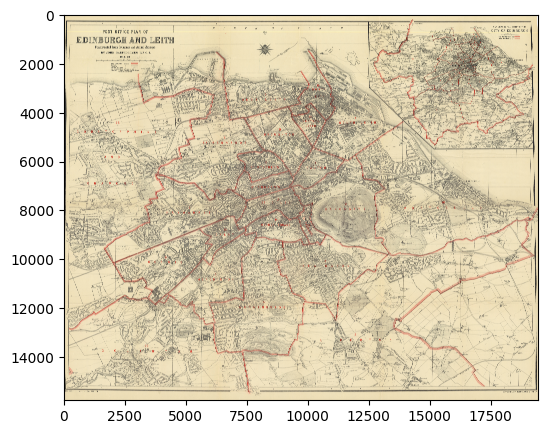

In [17]:
map_1 = cv.imread("../data/bart/82833386.27.tif")
fix_map_1 = rotate_crop_map(map_1)
show_map(fix_map_1)

1.4065170288085938


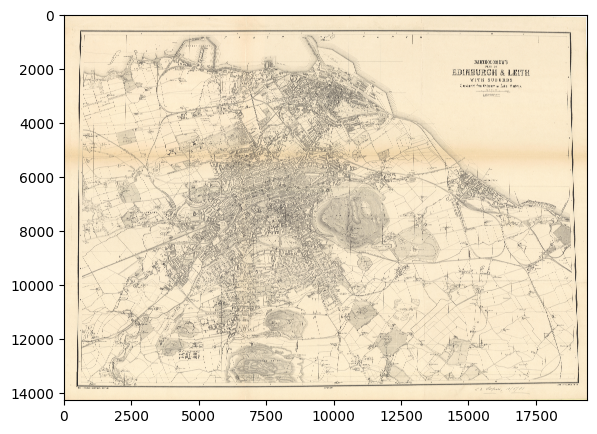

In [19]:
map_2 = cv.imread("../data/bart/90719482.27.tif")
fix_map_2 = rotate_crop_map(map_2)
show_map(fix_map_2)

In [3]:
minx = -3.190359
miny = 55.944128
maxx = -3.151644
maxy = 55.958644

In [4]:
(minx + maxx)/2

-3.1710015

In [5]:
(miny + maxy)/2

55.951386

In [17]:
# Open the GeoTIFF image

with rasterio.open("../data/bart/82833386.27.tif") as src:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
    british_crs_min = transformer.transform(miny, minx)
    british_crs_max = transformer.transform(maxy, maxx)
    
    print(british_crs_max)
    print(british_crs_min)
    
    min_pixels = src.index(*british_crs_min)
    max_pixels = src.index(*british_crs_max)

(328195.92792040284, 674557.2035510557)
(325751.07738906634, 672982.6551263053)


In [18]:
from rasterio.warp import transform

x, y = transform('epsg:4326', 'epsg:27700', [minx, maxx], [miny, maxy])

In [19]:
print(x,y)

[325751.07738906634, 328195.92792040284] [672982.6551263053, 674557.2035510557]


In [20]:
print(min_pixels, max_pixels)

(9204, 9487) (6910, 13050)


In [21]:
cutoff = map_1[max_pixels[0]:min_pixels[0], min_pixels[1]:max_pixels[1], :] 

In [22]:
map_1.shape

(16931, 20221, 3)

In [23]:
cutoff.shape

(2294, 3563, 3)

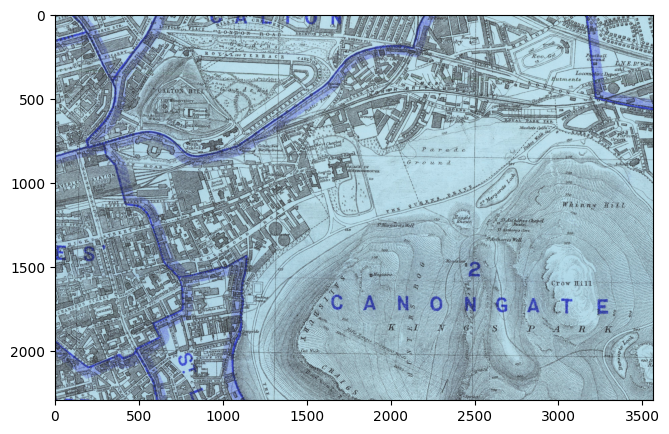

In [24]:
show_map(cutoff)

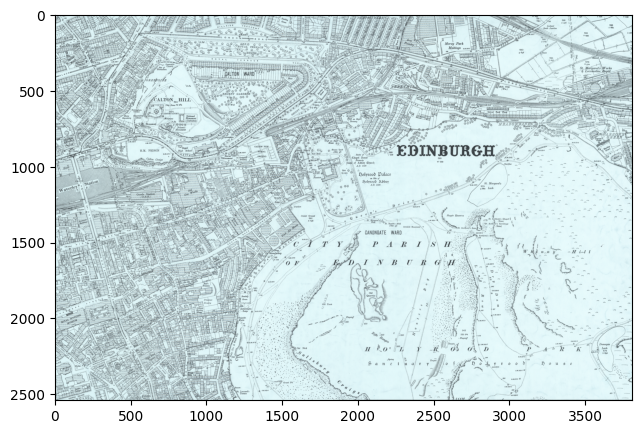

In [25]:
goal_map = cv.imread("../data/originals/17/82877412.tif")
show_map(goal_map)

In [26]:
goal_map.shape

(2541, 3812, 3)

In [27]:
cutoff.shape

(2294, 3563, 3)

In [28]:
x_1 = [-3.192112616595414,55.9423625178286]
x_2 = [
                  -3.149118538110902,
                  55.94277108265303
                ]
x_3 = [
                  -3.149638014166486,
                  55.96030038664902
                ]
x_4 = [
                  -3.192651513330189,
                  55.95989155384999
                ]

In [29]:
# Open the GeoTIFF image

with rasterio.open("../data/bart/82833386.27.tif") as src:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
    x_1 = transformer.transform(*x_1[::-1])
    x_2 = transformer.transform(*x_2[::-1])
    x_3 = transformer.transform(*x_3[::-1])
    x_4 = transformer.transform(*x_4[::-1])
    
    print(x_1)
    print(x_2)
    print(x_3)
    print(x_4)
    
    min_pixels = src.index(*x_1)
    max_pixels = src.index(*x_3)

(325638.16786914424, 672788.0607623197)
(328324.2308418056, 672788.0607623325)
(328324.2308418136, 674739.4605065592)
(325638.16786915215, 674739.4605065485)


In [30]:
cutoff = map_1[max_pixels[0]:min_pixels[0], min_pixels[1]:max_pixels[1], :] 

In [31]:
cutoff.shape

(2844, 3914, 3)

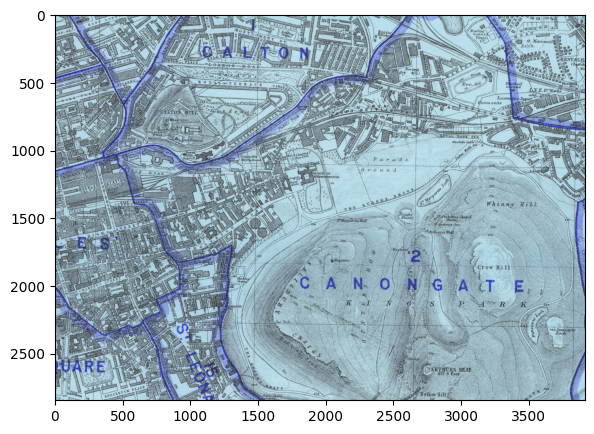

In [32]:
show_map(cutoff)

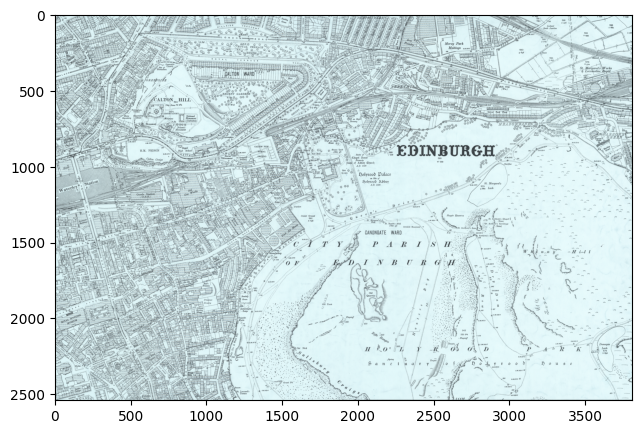

In [33]:
show_map(goal_map)

In [34]:
(h, w) = map_1.shape[:2]
angle = 1.1297225952148438
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, angle, 1.0)
rotated = cv.warpAffine(map_1, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

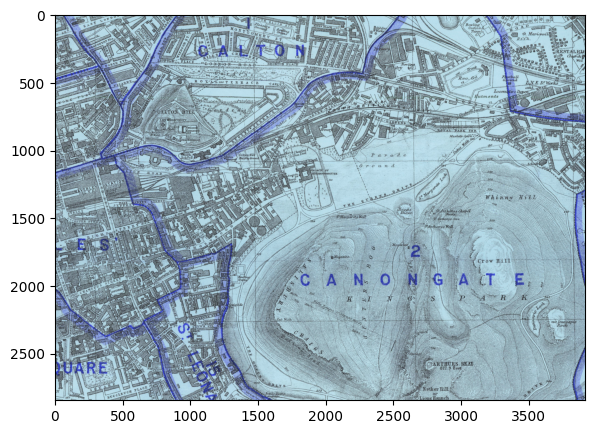

In [35]:
rotated_cutoff = rotated[max_pixels[0]:min_pixels[0], min_pixels[1]:max_pixels[1], :]
show_map(rotated_cutoff)

In [36]:
print(goal_map.shape)
print(rotated_cutoff.shape)

(2541, 3812, 3)
(2844, 3914, 3)


In [37]:
a = torch.from_numpy(rotated_cutoff)

In [ ]:
resized_cutoff = T.Resize(goal_map.shape[:2])(a)